## Totale 4/06/2019
### Esercizio 1 Punto 1
Alessandro Lodi<br>
Matricola 274425

### Notebook Init

In [1]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class args:
    filename = "net12062020.gml"
    scale = 40
    figsize = 10,10

In [4]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

### Drawing functions

In [5]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        
    plt.axis('off')
    plt.show()

In [6]:
# Graph reading
basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 20 nodes and 190 edges


## Prize Collecting Steiner Tree (PCST)

### Problem definition

>**Given**
> * A symmetric graph $G=(V,E)$ and a cost $c_e > 0$ for each edge in $E$;
> * A root node $\{0\}$;
> * A revenue $p_j > 0$ for each node $j \in V \setminus \{0\}$;

>
>**Find**
>A subtree $T$ rooted in $\{0\}$ that **maximizes** the sum of the revenues of 
>the nodes in $T$ **minus** the sum of the costs of the edges in $T$


### Formulation with *positional* variables (MTZ formulation)

#### Variables
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the arborescence} \\
0 \text{ otherwise}
\end{cases}
$$

$$
y_j = \begin{cases} 1 \text{ if node j is in the arborescence}\\
0 \text{ otherwise}
\end{cases}
$$

$$ 
u_j = \{\text{number of arcs in the dipath (if any) induced by $x$ from \{0\} to $j$}\}
$$

#### MTZ formulation

$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \setminus \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V\\
(n+1)x_{ij} + u_i - u_j &\le n \;\; \forall (i,j) \in A \\
x_{jk} &\le y_j \;\; \forall k \in \delta^+(j), \;\; \forall j \in V \setminus\{0\}\\
0 \le u_j & \le n \;\; \forall j \in V \\ 
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$


In [7]:
D = G.to_directed()
G.nodes(data=True)

NodeDataView({1: {'y': 39, 'x': 9}, 2: {'y': 29, 'x': 5}, 3: {'y': 13, 'x': 26}, 4: {'y': 33, 'x': 30}, 5: {'y': 42, 'x': 4}, 6: {'y': 26, 'x': 12}, 7: {'y': 18, 'x': 21}, 8: {'y': 47, 'x': 7}, 9: {'y': 28, 'x': 14}, 10: {'y': 14, 'x': 3}, 11: {'y': 45, 'x': 22}, 12: {'y': 41, 'x': 5}, 13: {'y': 49, 'x': 22}, 14: {'y': 10, 'x': 28}, 15: {'y': 1, 'x': 4}, 16: {'y': 36, 'x': 17}, 17: {'y': 28, 'x': 23}, 18: {'y': 49, 'x': 24}, 19: {'y': 37, 'x': 3}, 20: {'y': 9, 'x': 15}})

In [8]:
root = 1
pcst = gb.Model()

# Decision Variables
x = pcst.addVars(D.edges(), vtype=gb.GRB.BINARY, 
                 obj = [D[i][j]['cost'] for i,j in D.edges()], 
                 name = 'x')

y = pcst.addVars (G.nodes(), vtype = gb.GRB.BINARY, 
                 name = 'y')

u = pcst.addVars (G.nodes(), vtype = gb.GRB.CONTINUOUS, 
                  lb = 0.0, ub = G.number_of_nodes(),
                 name = 'u')


# Root is in the solution
pcst.addConstr(y[root] == 1, name = 'Fix_root')


# Each node has exactly one incoming arc
pcst.addConstrs((x.sum('*',j) == y[j] for j in G.nodes() if j != root), name='Node_in_deg')


# Precedence constraints (MTZ constraints)
pcst.addConstrs(((G.number_of_nodes() +  1) * x[i,j] + u[i] - u[j] <= G.number_of_nodes() for i,j in D.edges()),
                name = 'MTZ')


# Connectivity constraints
pcst.addConstrs((x[j,k] <= y[j] for j in G.nodes() 
                 if j != root for k in D.neighbors(j)), name = 'Connect')


pcst.update()
pcst.write('pcst.lp')

Academic license - for non-commercial use only - expires 2021-08-02
Using license file /opt/gurobi/gurobi.lic


In [9]:
# All nodes are in the solution
n_customer = len(G.nodes())
pcst.addConstr((y.sum('*') == n_customer), name='All_customers')

pcst.update()

## Net 1

In [10]:
# Net 1 constraints
pcst.addConstr(x.sum(root,'*') <= 4, name='Root_deg_out')

pcst.update()

In [11]:
pcst.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 763 rows, 420 columns and 2282 nonzeros
Model fingerprint: 0x354e3cfe
Variable types: 20 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e+02, 6e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 382 rows and 40 columns
Presolve time: 0.00s
Presolved: 381 rows, 380 columns, 1444 nonzeros
Variable types: 19 continuous, 361 integer (361 binary)
Found heuristic solution: objective 21257.000000

Root relaxation: objective 1.018162e+04, 43 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 10181.6190    0   10 21257.0000 10181.6190  52.1%     -    0s
H    0     0                    13939.000000 

Net 1:  12054.0


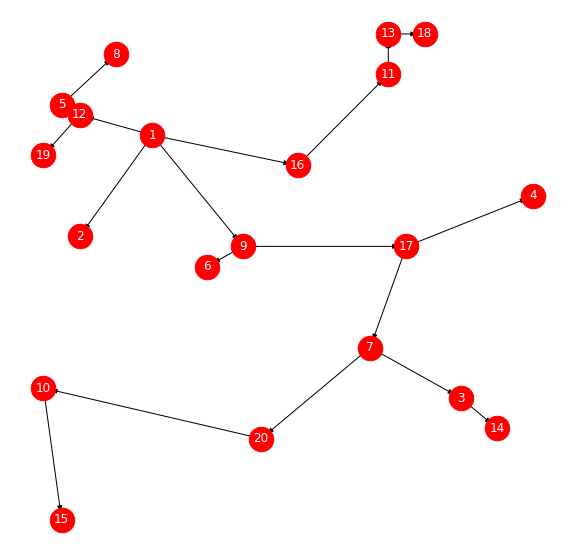

In [12]:
print("Net 1: ", pcst.objVal)
DrawSol(D,x)

## Net 2

In [13]:
pcst.remove(pcst.getConstrByName('Root_deg_out'))

# Net 2 constraints
pcst.addConstrs((x.sum(j,'*') + x.sum('*',j) <= 2 for j in G.nodes() if j != root and (j % 2) != 0), name='odd_deg')
pcst.addConstrs((x.sum(j,'*') + x.sum('*',j) <= 3 for j in G.nodes() if j != root and (j % 2) == 0), name='even_deg')

pcst.update()

In [14]:
pcst.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 781 rows, 420 columns and 2985 nonzeros
Model fingerprint: 0x2a8b06b8
Variable types: 20 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e+02, 6e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint odd_deg[7] by 1.000000000

Found heuristic solution: objective 37915.000000
Presolve removed 382 rows and 40 columns
Presolve time: 0.00s
Presolved: 399 rows, 380 columns, 1767 nonzeros
Variable types: 19 continuous, 361 integer (361 binary)

Root relaxation: objective 1.108376e+04, 47 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    

Net 2:  12344.0


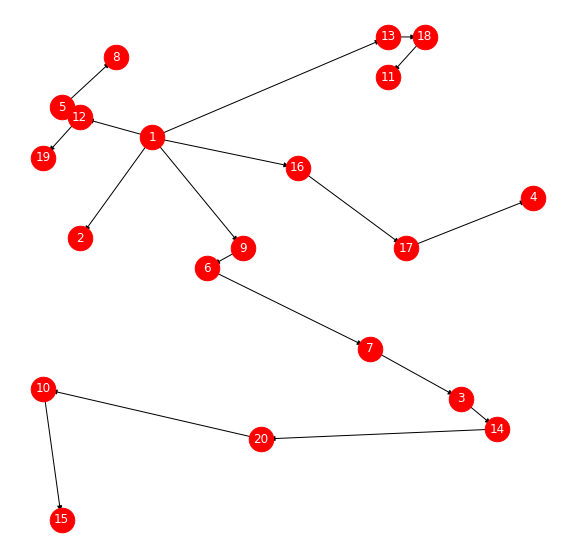

In [15]:
print("Net 2: ", pcst.objVal)
DrawSol(D,x)

## Net 3

In [16]:
constrs_to_remove = [const for const in pcst.getConstrs() if const.ConstrName.startswith('odd_deg') ]
pcst.remove(constrs_to_remove)
constrs_to_remove = [const for const in pcst.getConstrs() if const.ConstrName.startswith('even_deg') ]
pcst.remove(constrs_to_remove)

pcst.update()

Discarded solution information
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 765 rows, 420 columns and 2320 nonzeros
Model fingerprint: 0x540c70c9
Variable types: 20 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e+02, 6e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 382 rows and 40 columns
Presolve time: 0.00s
Presolved: 383 rows, 380 columns, 1479 nonzeros
Variable types: 19 continuous, 361 integer (361 binary)
Found heuristic solution: objective 31508.000000

Root relaxation: objective 1.935524e+03, 59 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1935.52381    0    8 31508.0000 1935.52381  93.9%     -    0s
H    0     0  

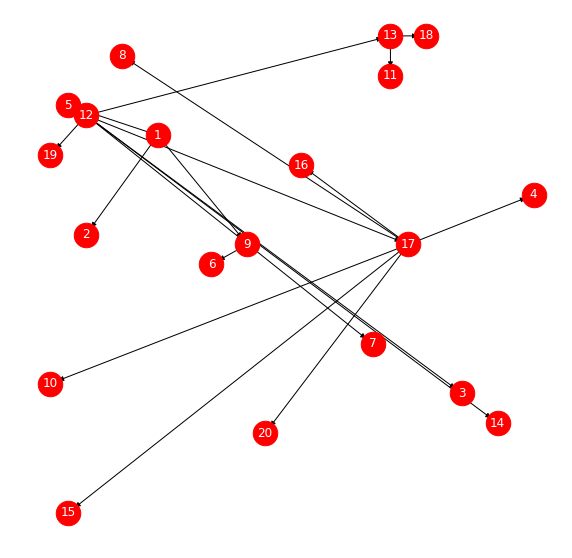

Discarded solution information
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 765 rows, 420 columns and 2320 nonzeros
Model fingerprint: 0xd79182d9
Variable types: 20 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e+02, 6e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 382 rows and 40 columns
Presolve time: 0.00s
Presolved: 383 rows, 380 columns, 1479 nonzeros
Variable types: 19 continuous, 361 integer (361 binary)
Found heuristic solution: objective 31508.000000

Root relaxation: objective 1.903762e+03, 66 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1903.76190    0    8 31508.0000 1903.76190  94.0%     -    0s
H    0     0  

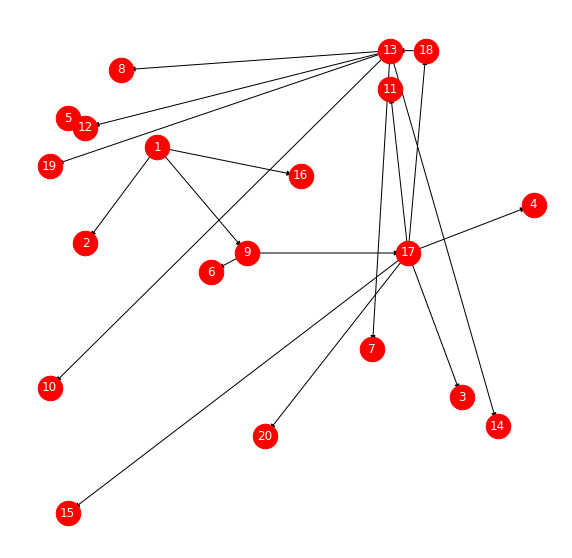

Discarded solution information
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 765 rows, 420 columns and 2320 nonzeros
Model fingerprint: 0xc398f5d6
Variable types: 20 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e+02, 6e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 382 rows and 40 columns
Presolve time: 0.00s
Presolved: 383 rows, 380 columns, 1479 nonzeros
Variable types: 19 continuous, 361 integer (361 binary)
Found heuristic solution: objective 31508.000000

Root relaxation: objective 4.734381e+03, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4734.38095    0   12 31508.0000 4734.38095  85.0%     -    0s
H    0     0  

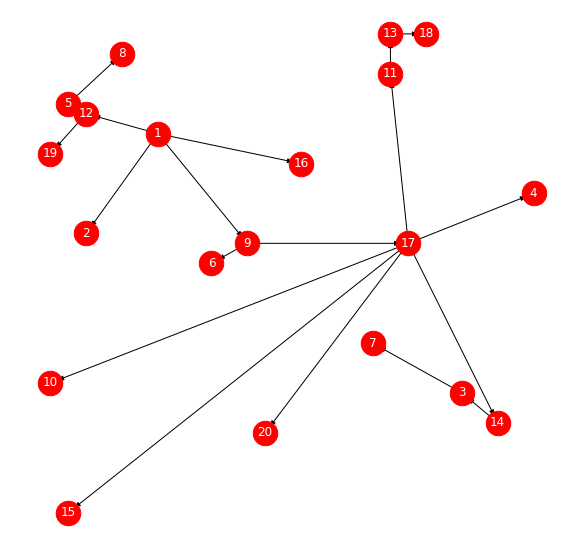

In [20]:
possible_hubs = [12,13,17]

previous_hub = -1

min_val = -1
min_hub = -1

for hub_loc in possible_hubs:
    if previous_hub != -1:
        for j in G.nodes():
            if j != root and j != previous_hub:
                x[previous_hub,j].Obj = D[previous_hub][j]['cost']
        pcst.remove(pcst.getConstrByName('hub_deg'))
    
    for j in G.nodes():
        if j != root and j != hub_loc:
            x[hub_loc,j].Obj = 0
    
    pcst.addConstr(x.sum(hub_loc,'*') <= 6, name='hub_deg')
    
    pcst.update()
    pcst.reset()
    pcst.optimize()
    
    if min_val > pcst.objVal or min_val == -1:
        min_val = pcst.objVal
        min_hub = hub_loc
    
    print("Cost with warehouse", hub_loc, " is " , pcst.objVal)

    DrawSol(D,x)
    previous_hub = hub_loc

In [22]:
print("The best hub is", min_hub, "with cost ", min_val)

The best warehouse is 12 with profit 2341.0
